In [2]:
import re, string 
import pandas as pd 
from time import time  
from collections import defaultdict
import spacy
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from nltk.corpus import stopwords
import numpy as np
STOPWORDS = set(stopwords.words('english'))
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('bbc-text.csv')

In [4]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [5]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    # Remove a sentence if it is only one word long
    if len(text) > 2:
        return ' '.join(word for word in text.split() if word not in STOPWORDS)

df_clean = pd.DataFrame(df.text.apply(lambda x: clean_text(x)))

In [6]:
df_clean.head()

,text
0,tv future hands viewers home theatre systems p...
1,worldcom boss left books alone former worldcom...
2,tigers wary farrell gamble leicester say rushe...
3,yeading face newcastle fa cup premiership side...
4,ocean twelve raids box office ocean twelve cri...


In [7]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

df_clean["text_lemmatize"] =  df_clean.apply(lambda x: lemmatizer(x['text']), axis=1)

In [8]:
df_clean.head()

,text,text_lemmatize
0,tv future hands viewers home theatre systems p...,tv future hand viewer home theatre system plas...
1,worldcom boss left books alone former worldcom...,worldcom boss leave book alone former worldcom...
2,tigers wary farrell gamble leicester say rushe...,tiger wary farrell gamble leicester say rush m...
3,yeading face newcastle fa cup premiership side...,yeade face newcastle fa cup premiership side n...
4,ocean twelve raids box office ocean twelve cri...,ocean twelve raid box office ocean twelve crim...


In [9]:
df_clean['text_lemmatize_clean'] = df_clean['text_lemmatize'].str.replace('-PRON-', '')

In [10]:
sentences = [row.split() for row in df_clean['text_lemmatize_clean']]
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

25218

In [11]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['say', 'mr', 'year', 'would', 'make', 'also', 'people', 'new', 'one', 'take']

In [12]:
# min_count: minimum number of occurrences of a word in the corpus to be included in the model.
# window: the maximum distance between the current and predicted word within a sentence.
# size: the dimensionality of the feature vectors
# workers: I know my system is having 4 cores, 
w2v_model = Word2Vec(min_count=200,
                     window=5,
                     workers=4)

In [13]:
# this line of code to prepare the model vocabulary
w2v_model.build_vocab(sentences)

In [14]:
# train word vectors
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=100)

(19702931, 47810300)

In [15]:
# As we do not plan to train the model any further, 
# we are calling init_sims(), which will make the model much more memory-efficient
w2v_model.init_sims(replace=True)

/var/folders/xf/y0yb8j3d5cdc9fs6prv5ht2h0000gn/T/ipykernel_95775/1253622950.py:3: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


In [16]:
# Explore the model
w2v_model.wv.most_similar(positive=['economy'])

[('economic', 0.659260630607605),
 ('growth', 0.47827911376953125),
 ('rise', 0.4499658942222595),
 ('fall', 0.37214577198028564),
 ('bank', 0.35323566198349),
 ('oil', 0.35069578886032104),
 ('increase', 0.3478289842605591),
 ('government', 0.3467646539211273),
 ('figure', 0.3440563678741455),
 ('dollar', 0.3388585150241852)]

In [17]:
w2v_model.wv.most_similar(positive=['president'])

[('us', 0.34279781579971313),
 ('leader', 0.311244398355484),
 ('we', 0.2995033264160156),
 ('mr', 0.2940312922000885),
 ('state', 0.28750187158584595),
 ('chief', 0.28514161705970764),
 ('minister', 0.2712598741054535),
 ('job', 0.2699819803237915),
 ('oil', 0.2654430866241455),
 ('economy', 0.25972408056259155)]

In [18]:
# how similar are these two words to each other 
w2v_model.wv.similarity('company', 'business')

0.4056128

In [21]:
def tsne_plot(model):
    "Create TSNE model and plot it"
    vocab = model.wv
    
    vocab_size = len(vocab)
    embeddings_size = vocab.vector_size
    
    labels = []
    tokens = np.empty((vocab_size, embeddings_size))

    
    for idx, word in enumerate(vocab.key_to_index):
        tokens[idx] = vocab[word]
        labels.append(word)
            
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(18, 18)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.xlabel('dim 1')
    plt.ylabel('dim 2')
    plt.title('t-SNE visualization of word embeddings')
    plt.show()

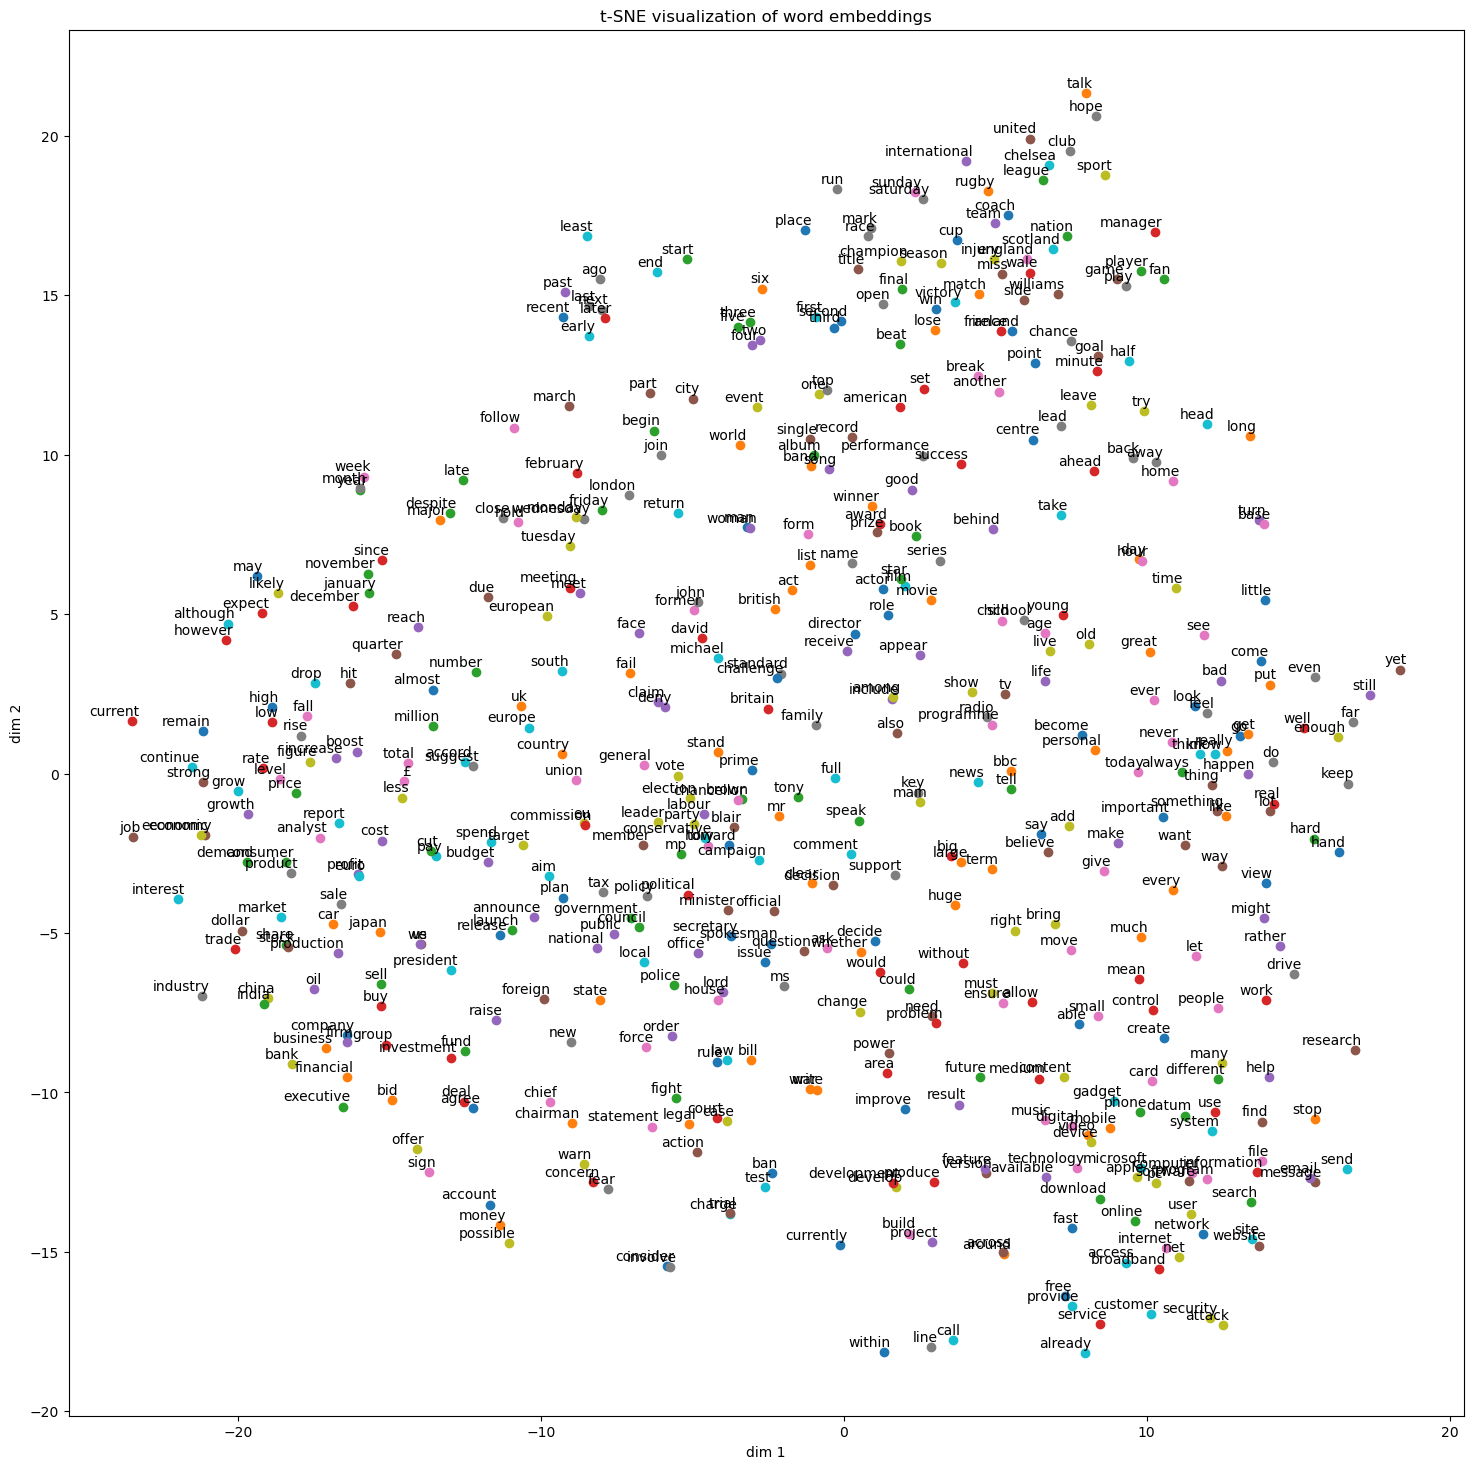

In [22]:
# Use t-SNE to represent high-dimensional data 
# and the underlying relationships between vectors in a lower-dimensional space.
tsne_plot(w2v_model)

In [2]:
# from gensim.models import KeyedVectors

# filename = 'GoogleNews-vectors-negative300.bin.gz'
# model = KeyedVectors.load_word2vec_format(filename, binary=True)
# calculate: (king - man) + woman = ?
# result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
# print(result)